In [1]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
#SEARCHING FOR P100
import os
import time
x=!nvidia-smi
count=0
for i in x:
    if "============" in i:
        count+=1
        break
    count+=1
if 'p100' in x[count].lower():
    print("found")
else:
    print(x[count])
    time.sleep(1)
    #os._exit(00)

|   0  GeForce GT 730     WDDM  | 00000000:01:00.0 N/A |                  N/A |


In [4]:
import tensorflow
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 537386547629555113
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5323810436811833637
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11235661972005239802
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
# Resizinig all the images to (224,224)
IMAGE_SIZE = [224,224]

train_path = 'Alzheimer_s Dataset/train'
test_path = 'Alzheimer_s Dataset/test'

In [6]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


# **ResNet50**

In [8]:
resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [9]:
for layer in resnet.layers:
  layer.trainable = False

In [10]:
x = Flatten()(resnet.output)

In [11]:
prediction = Dense(4, activation='softmax')(x)

In [12]:
model = Model(inputs = resnet.inputs, outputs = prediction)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [13]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = model.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=1, validation_steps=1,callbacks=[callback])

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 1.2274 - accuracy: 0.4688 - val_loss: 1.4605 - val_accuracy: 0.2812
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 6.2613 - accuracy: 0.1875 - val_loss: 10.3082 - val_accuracy: 0.5625
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 15.9104 - accuracy: 0.4375 - val_loss: 9.7397 - val_accuracy: 0.4688
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 10.4146 - accuracy: 0.4688 - val_loss: 2.9941 - val_accuracy: 0.5312


In [15]:
model.save('model1.h5')

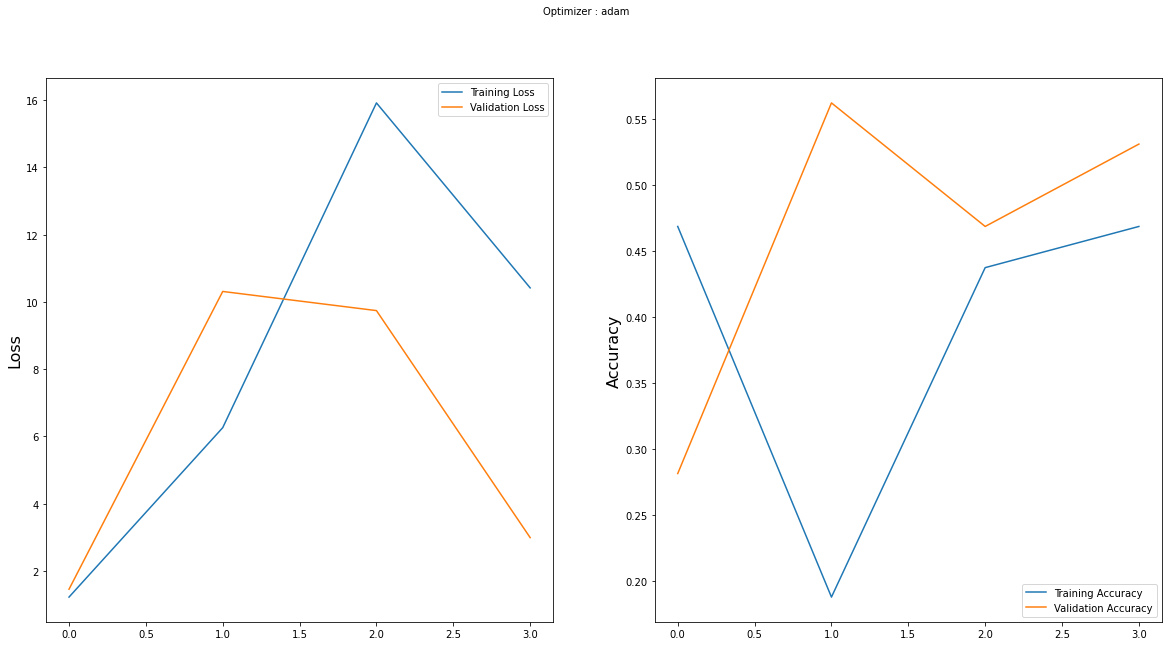

In [16]:
import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **For InceptionV3 with optimiser adam**

In [17]:
# create the base pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x2 = base_model.output
x2 = GlobalAveragePooling2D()(x2)

In [18]:
predictions = Dense(4, activation='softmax')(x2)

# this is the model we will train
models = Model(inputs=base_model.input, outputs=predictions)
models.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
for layer in base_model.layers:
    layer.trainable = False


In [20]:
models.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
hist = models.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[callback])

Epoch 1/20
161/161 [==============================] - 163s 1s/step - loss: 1.0092 - accuracy: 0.5157 - val_loss: 0.9890 - val_accuracy: 0.5262
Epoch 2/20
161/161 [==============================] - 153s 952ms/step - loss: 0.9104 - accuracy: 0.5690 - val_loss: 0.9541 - val_accuracy: 0.5410
Epoch 3/20
161/161 [==============================] - 153s 950ms/step - loss: 0.8973 - accuracy: 0.5806 - val_loss: 0.9608 - val_accuracy: 0.5278
Epoch 4/20
161/161 [==============================] - 154s 957ms/step - loss: 0.8831 - accuracy: 0.5776 - val_loss: 1.1009 - val_accuracy: 0.4801
Epoch 5/20
161/161 [==============================] - 153s 948ms/step - loss: 0.8415 - accuracy: 0.6052 - val_loss: 0.9405 - val_accuracy: 0.5434
Epoch 6/20
161/161 [==============================] - 154s 955ms/step - loss: 0.8492 - accuracy: 0.5997 - val_loss: 0.9509 - val_accuracy: 0.5317
Epoch 7/20
161/161 [==============================] - 153s 949ms/step - loss: 0.8364 - accuracy: 0.6020 - val_loss: 1.0380 - va

In [21]:
models.save('model2.h5')

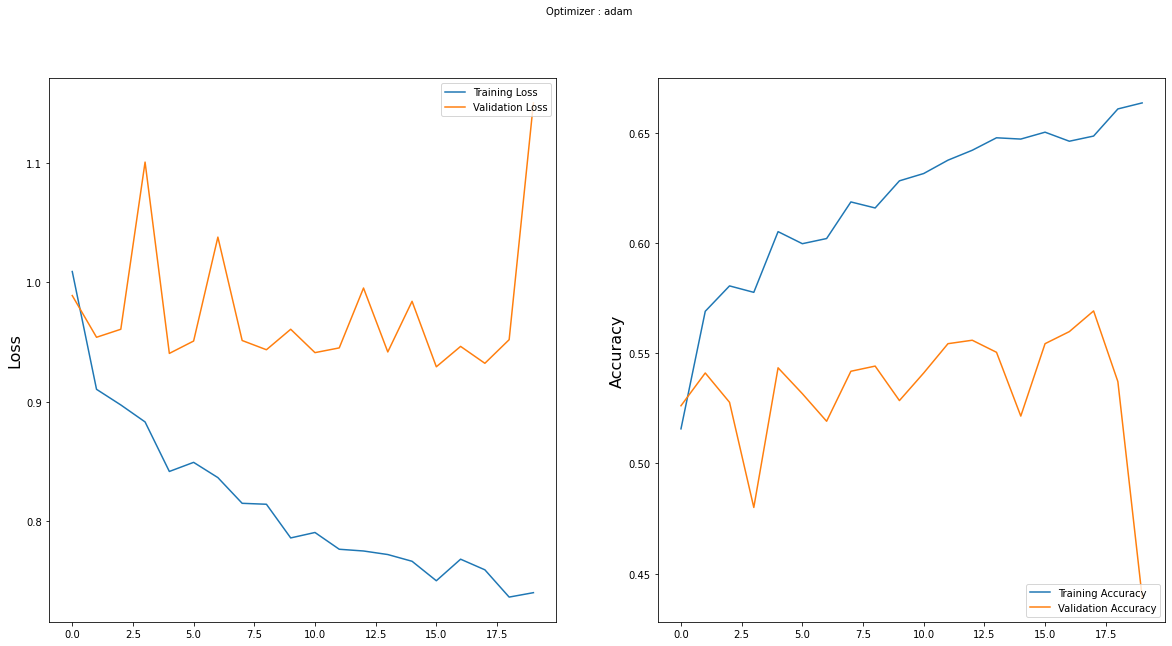

In [22]:
import matplotlib.pyplot as plt

x=hist
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


# **INCEPTION RESNET V2**

In [23]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import Model
inc=InceptionResNetV2(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [24]:
x3 = Flatten()(inc.output)
predictionss = Dense(4, activation='softmax')(x3)

In [25]:
modelss = Model(inputs = inc.inputs, outputs = predictionss)
modelss.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
modelss.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
r2 = modelss.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set))
x=r2

Epoch 1/20
161/161 [==============================] - 1724s 11s/step - loss: 1.7700 - accuracy: 0.5226 - val_loss: 1390981376.0000 - val_accuracy: 0.5004
Epoch 2/20
161/161 [==============================] - 1715s 11s/step - loss: 1.5699 - accuracy: 0.5235 - val_loss: 14233.8203 - val_accuracy: 0.3362
Epoch 3/20
 63/161 [==========>...................] - ETA: 16:49 - loss: 1.0846 - accuracy: 0.5784

In [ ]:
modelss.save('model3.h5')

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **MobileNet**

In [ ]:
from tensorflow.keras.applications import MobileNet, MobileNetV2
mob = MobileNet(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
x1= Flatten()(mob.output)
prediction1 = Dense(4, activation='softmax')(x1)
model12 = Model(inputs = mob.inputs, outputs = prediction1)
model12.summary()
model12.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
r1 = model12.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set))

In [ ]:
model12.save('model4.h5')

In [ ]:
import matplotlib.pyplot as plt

x=r1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **DenseNet121**

In [ ]:
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, ResNet50V2,ResNet101V2,ResNet152V2

In [ ]:
des121=DenseNet121(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
x1= Flatten()(des121.output)
prediction1 = Dense(4, activation='softmax')(x1)
model1 = Model(inputs = des121.inputs, outputs = prediction1)
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
r1 = model1.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set))

In [ ]:
model1.save('model_des.h5')

In [ ]:
import matplotlib.pyplot as plt

x=r1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **DenseNet169**

In [ ]:
des169=DenseNet169(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
x1= Flatten()(des169.output)
prediction1 = Dense(4, activation='softmax')(x1)
model1 = Model(inputs = des169.inputs, outputs = prediction1)
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
r1 = model1.fit(train_set, validation_data=test_set, epochs=200, steps_per_epoch=len(train_set), validation_steps=len(test_set))

In [ ]:
model1.save('model6.h5')

In [ ]:
import matplotlib.pyplot as plt

x=r1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()